In [1]:
!pip install matplotlib
!pip install hazm
!pip install mplcursors
!pip install Flask

In [8]:
# Import librarys
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import unicode_literals
import nltk
import numpy as np
from sklearn.preprocessing import LabelEncoder
from hazm import Normalizer, word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from nltk.classify.scikitlearn import SklearnClassifier
from hazm.utils import stopwords_list
from hazm import Lemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import mplcursors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression

from flask import Flask, request, jsonify
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import pickle

Step 2 - Data Loading

In [3]:
input_file = 'Hamshahri-Corpus.txt'
#input_file = 'sample-newspaper.txt'
output_file = 'Hamshahri-Table.csv'

# Process the file line by line
data = []
data_for_fields = [{'.DID': '', '.Date': '', '.Cat': '', 'Text': ''}]
text = ''
dict = {}
with open(input_file, 'r', encoding='utf-8') as infile:
    with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:

        fieldnames = set().union(*(d.keys() for d in data_for_fields))
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for line in infile:
            line = line.strip()

            if line.startswith('.DID') or line.startswith('.Date') or line.startswith('.Cat'):
                if text:
                    dict['Text'] = text
                    text=''
                    writer.writerow(dict)
                    dict = {}

                key, value = line.split('\t')
                dict[key] = value

            else:
                text = str(text + line + ' ')

        dict['Text'] = text
        writer.writerow(dict)

In [4]:
# Read generated CSV file
df = pd.read_csv('Hamshahri-Table.csv')

df.head(5)

,.Cat,Text,.Date,.DID
0,adabh,جاودانگي در زندگي گروهي از طريق هنر نگاهي به ن...,75\04\02,1S1
1,adabh,رويدادهاي هنري جهان نمايشگاه هنر در خدمت ديكتا...,75\04\02,2S1
2,adabh,برديوار نگارخانه ها گالري گلستان: نمايشگاه طرح...,75\04\02,3S1
3,ejtem,بازي را جدي بگيريم مطالعه اي مقدماتي پيرامون ن...,75\04\02,4S1
4,elmfa,تخته سياه و غباري كه سترده نمي شود... اشاره; ب...,75\04\02,5S1


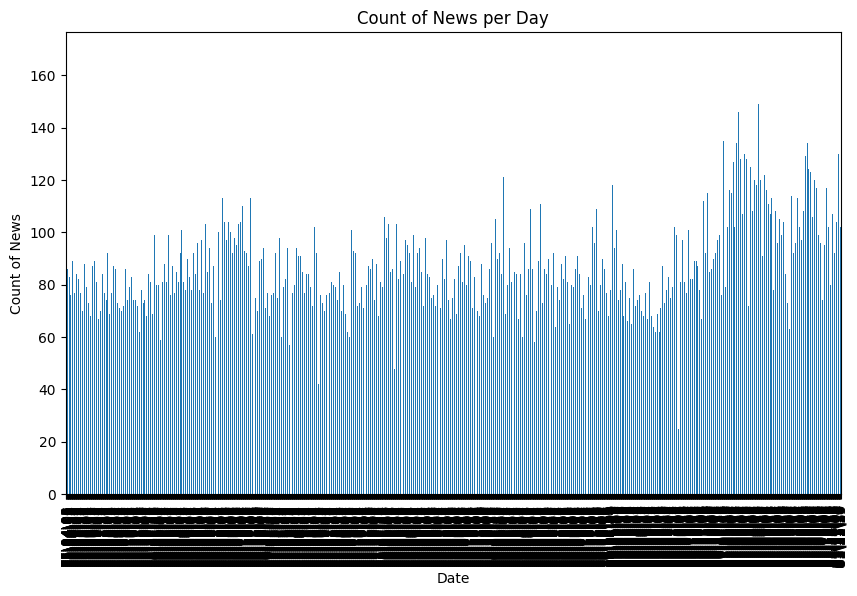

In [3]:
news_count = df.groupby(df['.Date']).size()

# Plot the count of news using Matplotlib
plt.figure(figsize=(10, 6))
news_count.plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Count of News')
plt.title('Count of News per Day')
plt.show()

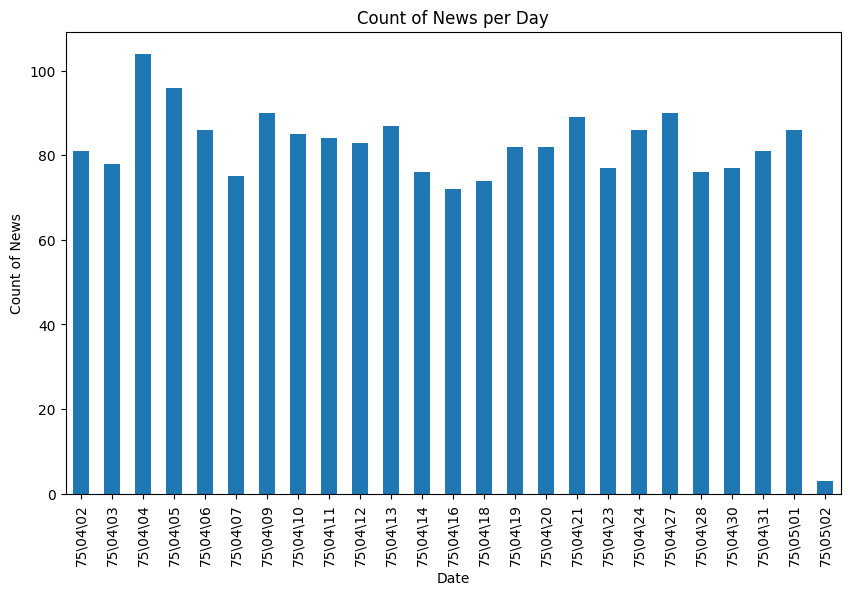

In [30]:
# Group the data by date and count the number of occurrences
df_for_plot = pd.read_csv('Hamshahri-Table.csv', nrows=2000)

news_count = df_for_plot.groupby(df['.Date']).size()

# Plot the count of news using Matplotlib
plt.figure(figsize=(10, 6))
news_count.plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Count of News')
plt.title('Count of News per Day')
plt.show()

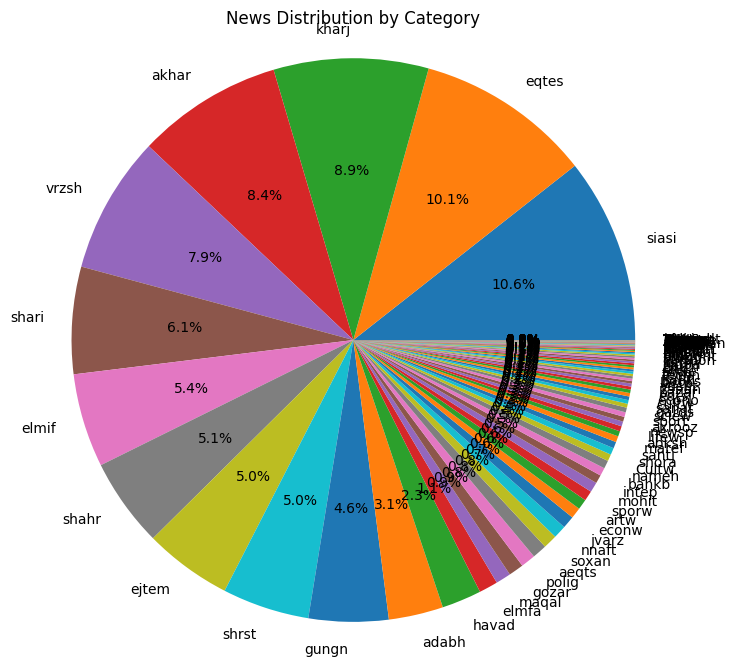

In [35]:
# Calculate the count of news by category
news_count = df['.Cat'].value_counts()

# Plot the count of news using Matplotlib
plt.figure(figsize=(8, 8))
plt.pie(news_count, labels=news_count.index, autopct='%1.1f%%')
plt.title('News Distribution by Category')
plt.axis('equal')
plt.show()

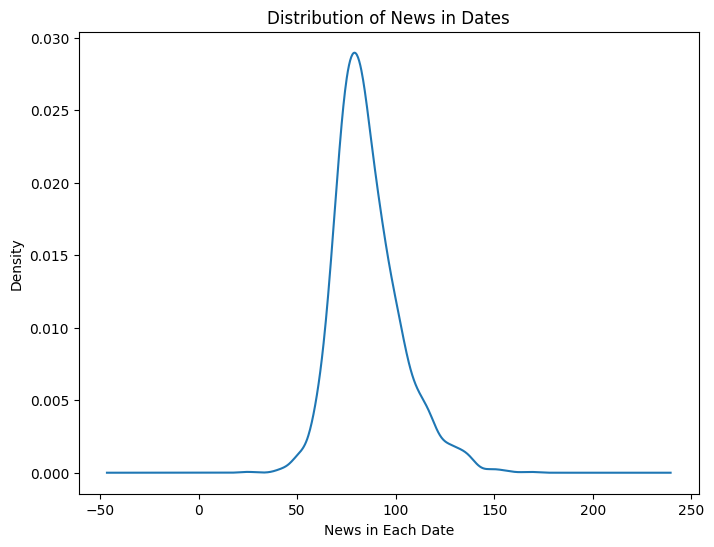

In [40]:
# Plot the distribution using a density plot
plt.figure(figsize=(8, 6))
df['.Date'].value_counts().plot(kind='density')
plt.xlabel('News in Each Date')
plt.ylabel('Density')
plt.title('Distribution of News in Dates')
plt.show()

Step 4 – Preprocessing

In [5]:
# Preprocess texts
df['Text'] = df['Text'].str.replace(r'تومان|ریال|دلار|\$|تومن|هزار|میلیون|یورو', 'moneysymb', regex=True)
df['Text'] = df['Text'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phonenumbr', regex=True)
df['Text'] = df['Text'].str.replace(r'\d+(\.\d+)?', 'numbr', regex=True)
df['Text'] = df['Text'].str.replace(r'[^\w\d\s]', ' ', regex=True)
df['Text'] = df['Text'].str.replace(r'\s+', ' ', regex=True)
df['Text'] = df['Text'].str.replace(r'^\s+|\s+?$', '', regex=True)
df['Text'] = df['Text'].str.lower()

normalizer = Normalizer()
df['Text'] = df['Text'].apply(normalizer.normalize)
df['Text'] = df['Text'].apply(word_tokenize)

df.head(5)

,.Cat,Text,.Date,.DID
0,adabh,"[جاودانگی, در, زندگی, گروهی, از, طریق, هنر, نگ...",75\04\02,1S1
1,adabh,"[رویدادهای, هنری, جهان, نمایشگاه, هنر, در, خدم...",75\04\02,2S1
2,adabh,"[بردیوار, نگارخانه‌ها, گالری, گلستان, نمایشگاه...",75\04\02,3S1
3,ejtem,"[بازی, را, جدی, بگیریم, مطالعه‌ای, مقدماتی, پی...",75\04\02,4S1
4,elmfa,"[تخته‌سیاه, و, غباری, که, سترده, نمی‌شود, اشار...",75\04\02,5S1


In [6]:
# Stop words
stopwords = set(stopwords_list())
df['Text'] = df['Text'].apply(lambda x:[term for term in x if term not in stopwords])

df.head(5)

,.Cat,Text,.Date,.DID
0,adabh,"[جاودانگی, زندگی, طریق, هنر, نگاهی, نمایشگاه, ...",75\04\02,1S1
1,adabh,"[رویدادهای, هنری, جهان, نمایشگاه, هنر, خدمت, د...",75\04\02,2S1
2,adabh,"[بردیوار, نگارخانه‌ها, گالری, گلستان, نمایشگاه...",75\04\02,3S1
3,ejtem,"[بازی, بگیریم, مطالعه‌ای, مقدماتی, پیرامون, نق...",75\04\02,4S1
4,elmfa,"[تخته‌سیاه, غباری, سترده, اشاره, رغم, گسترش, ت...",75\04\02,5S1


In [7]:
ps = Lemmatizer()
df['Text'] = df['Text'].apply(lambda x: [ps.lemmatize(term) for term in x])

df.head(5)

,.Cat,Text,.Date,.DID
0,adabh,"[جاودانگی, زندگی, طریق, هنر, نگاه, نمایشگاه, آ...",75\04\02,1S1
1,adabh,"[رویداد, هنر, جهان, نمایشگاه, هنر, خدمت, دیکتا...",75\04\02,2S1
2,adabh,"[بردیوار, نگارخانه, گالری, گلستان, نمایشگاه, ط...",75\04\02,3S1
3,ejtem,"[بازی, گرفت#گیر, مطالعه, مقدماتی, پیرامون, نقش...",75\04\02,4S1
4,elmfa,"[تخته‌سیاه, غبار, سترده, اشاره, رغم, گسترش, تو...",75\04\02,5S1


Step 5 - Feature Engineering

In [9]:
# Define the batch size
batch_size = 50

# Create an empty DataFrame to store the final TF-IDF matrix
tfidf_df = pd.DataFrame()

# Iterate over a part of the dataset in batches(because of time complexity) 100 -> len(df)
for i in range(0, 100, batch_size):
    # Extract the batch of texts
    texts = df['Text'].iloc[i:i+batch_size].tolist()

    # Create a TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # Convert non-string elements to strings
    texts = [str(text) for text in texts]

    # Apply the TF-IDF vectorizer to the batch of texts
    tfidf_matrix = vectorizer.fit_transform(texts)

    # Convert the TF-IDF matrix to a DataFrame for the batch
    batch_tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    # Append the batch TF-IDF DataFrame to the final DataFrame
    tfidf_df = pd.concat([tfidf_df, batch_tfidf_df], ignore_index=True)

    # Save the updated TF-IDF DataFrame to a file
    tfidf_df.to_csv('tfidf_results.csv', index=False)

In [10]:
# Convert the text column to string
df['Text'] = df['Text'].astype(str)

# Filter the DataFrame for relevant columns and "ناتو" occurrences
filtered_df = df[['.Date', 'Text']].loc[df['Text'].str.contains("ناتو")]

# Calculate the frequency of "ناتو" for each time interval
frequency = filtered_df.groupby('.Date').size()

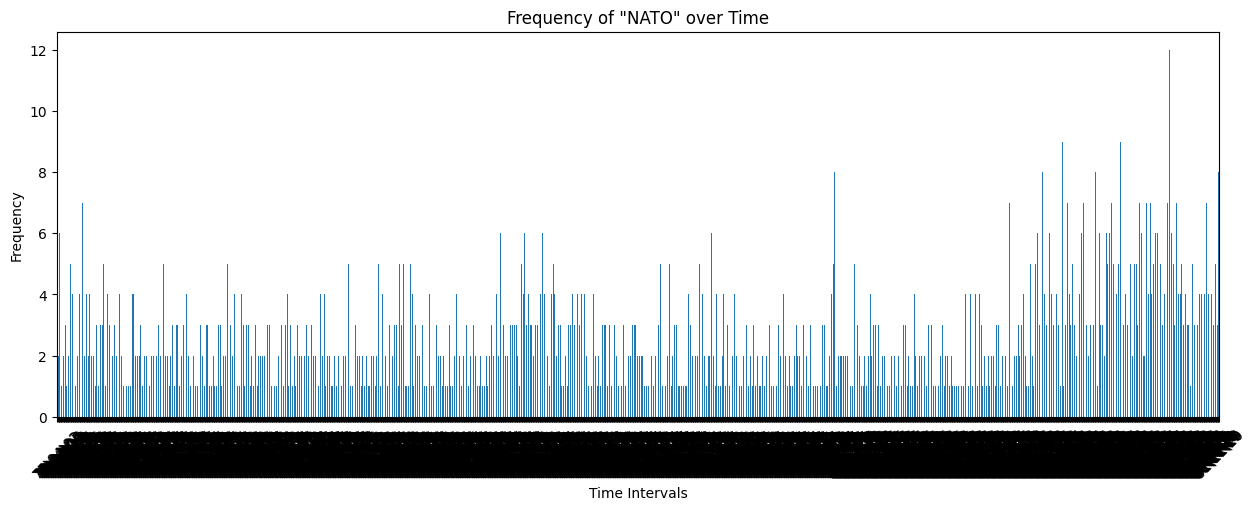

In [27]:
# Set the figure size
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the results
frequency.plot(kind='bar')
plt.xlabel('Time Intervals')
plt.ylabel('Frequency')
plt.title('Frequency of "NATO" over Time')
plt.xticks(rotation=45)

plt.show()

Step 6 - Dimensionality Reduction

In [20]:
# Make a smaller dataframe for faster execution
subset_df = df.head(2000)

# Preprocess the text data using TF-IDF
tfidf_matrix = vectorizer.fit_transform(subset_df['Text'])

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

# Perform t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(tfidf_matrix.toarray())

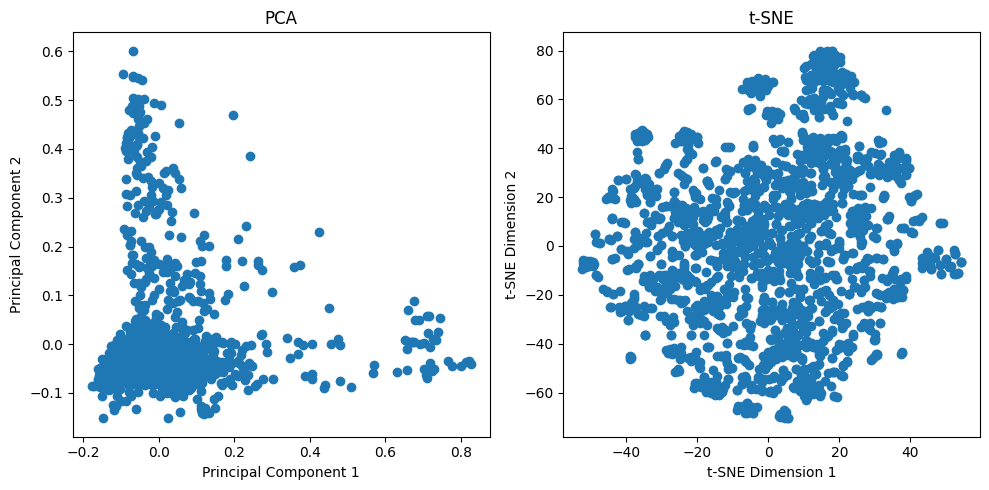

In [15]:
# Visualize the reduced data using scatter plots
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')

plt.subplot(122)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE')

plt.tight_layout()
plt.show()

Step 7 - Clustering

In [25]:
# Perform K-means clustering
num_clusters = 14
kmeans = KMeans(n_clusters= num_clusters, random_state=42)
kmeans.fit(pca_result)

# Get the cluster labels for each data point
cluster_labels_pca = kmeans.labels_

# Assign the cluster labels back to the DataFrame
subset_df['cluster_label'] = cluster_labels_pca

# Print the distribution of data points across clusters
print(subset_df['cluster_label'].value_counts())

# Perform further analysis on each cluster as needed
for cluster_id in range(num_clusters):
    cluster_data = subset_df[subset_df['cluster_label'] == cluster_id]

cluster_label
1     437
4     350
13    290
5     289
12    220
0     123
6      50
10     50
8      43
2      43
7      40
9      34
3      19
11     12
Name: count, dtype: int64


E:\University\M.Sc\Terms\Term2\Applied Machine Learning\Project\Codes\1\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\PooriA\AppData\Local\Temp\ipykernel_18852\2099038857.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['cluster_label'] = cluster_labels_pca


In [26]:
# Perform K-means clustering
num_clusters = 14
kmeans = KMeans(n_clusters= num_clusters, random_state=42)
kmeans.fit(tsne_result)

# Get the cluster labels for each data point
cluster_labels_tnse = kmeans.labels_

# Assign the cluster labels back to the DataFrame
subset_df['cluster_label'] = cluster_labels_tnse

# Print the distribution of data points across clusters
print(subset_df['cluster_label'].value_counts())

# Perform further analysis on each cluster as needed
for cluster_id in range(num_clusters):
    cluster_data = subset_df[subset_df['cluster_label'] == cluster_id]

cluster_label
13    195
5     191
6     154
2     154
9     154
1     150
11    149
12    141
8     139
4     136
0     126
3     110
7     109
10     92
Name: count, dtype: int64


E:\University\M.Sc\Terms\Term2\Applied Machine Learning\Project\Codes\1\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\PooriA\AppData\Local\Temp\ipykernel_18852\1446758836.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['cluster_label'] = cluster_labels_tnse


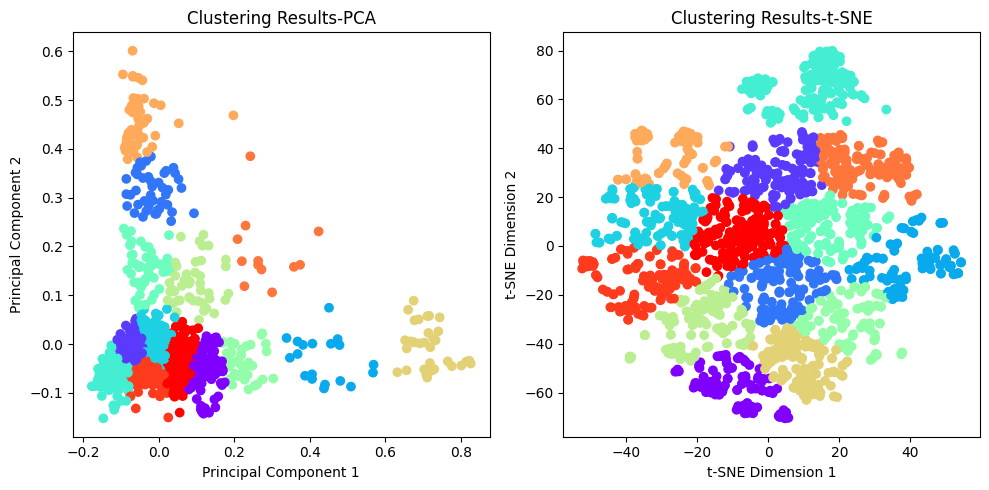

In [27]:
# Get the cluster labels from the DataFrame
cluster_labels = subset_df['cluster_label']

# Visualize the reduced data using scatter plots
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels_pca, cmap='rainbow')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering Results-PCA')

plt.subplot(122)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=cluster_labels_tnse, cmap='rainbow')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Clustering Results-t-SNE')

plt.tight_layout()
plt.show()

Step 8 - Storage

E:\University\M.Sc\Terms\Term2\Applied Machine Learning\Project\Codes\1\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\University\M.Sc\Terms\Term2\Applied Machine Learning\Project\Codes\1\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\University\M.Sc\Terms\Term2\Applied Machine Learning\Project\Codes\1\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\University\M.Sc\

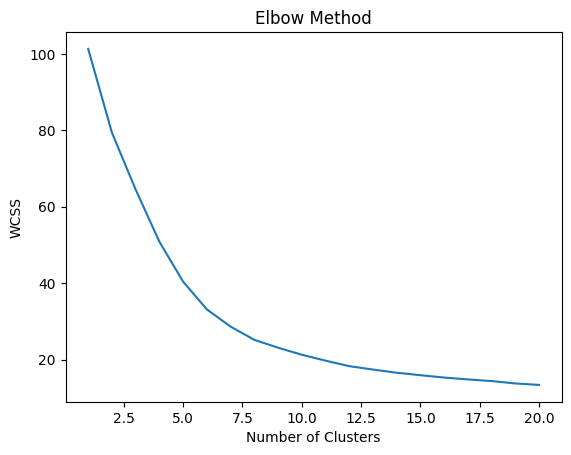

In [30]:
# Determine the optimal number of clusters using the elbow method
# Within-Cluster Sum of Squares
wcss = []

# Maximum number of clusters to test
max_clusters = 20

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(tfidf_matrix_new)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, max_clusters + 1), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [49]:
# Make a smaller dataframe for faster execution
subset_df = df.head(2000)

# Preprocess the text data using TF-IDF
tfidf_matrix_new = vectorizer.fit_transform(subset_df['Text'])

# Perform dimensionality reduction using PCA
pca = PCA(n_components=5)
tfidf_matrix_new = pca.fit_transform(tfidf_matrix_new.toarray())

# Perform K-means clustering on the original data
num_clusters = 8
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix_new)

# Get the cluster labels for each data point
cluster_labels = kmeans.labels_

# Assign the cluster labels back to the DataFrame
subset_df['cluster_label'] = cluster_labels

subset_df.head(5)

E:\University\M.Sc\Terms\Term2\Applied Machine Learning\Project\Codes\1\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\PooriA\AppData\Local\Temp\ipykernel_18852\1024112587.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['cluster_label'] = cluster_labels


,.Cat,Text,.Date,.DID,cluster_label
0,adabh,"['جاودانگی', 'زندگی', 'طریق', 'هنر', 'نگاه', '...",75\04\02,1S1,6
1,adabh,"['رویداد', 'هنر', 'جهان', 'نمایشگاه', 'هنر', '...",75\04\02,2S1,1
2,adabh,"['بردیوار', 'نگارخانه', 'گالری', 'گلستان', 'نم...",75\04\02,3S1,0
3,ejtem,"['بازی', 'گرفت#گیر', 'مطالعه', 'مقدماتی', 'پیر...",75\04\02,4S1,6
4,elmfa,"['تخته\u200cسیاه', 'غبار', 'سترده', 'اشاره', '...",75\04\02,5S1,1


In [50]:
# Save the result as a file
subset_df.to_csv('clustered_sample_data.csv', index=False)

pd.read_csv('clustered_sample_data.csv').head(5)

,.Cat,Text,.Date,.DID,cluster_label
0,adabh,"['جاودانگی', 'زندگی', 'طریق', 'هنر', 'نگاه', '...",75\04\02,1S1,6
1,adabh,"['رویداد', 'هنر', 'جهان', 'نمایشگاه', 'هنر', '...",75\04\02,2S1,1
2,adabh,"['بردیوار', 'نگارخانه', 'گالری', 'گلستان', 'نم...",75\04\02,3S1,0
3,ejtem,"['بازی', 'گرفت#گیر', 'مطالعه', 'مقدماتی', 'پیر...",75\04\02,4S1,6
4,elmfa,"['تخته\u200cسیاه', 'غبار', 'سترده', 'اشاره', '...",75\04\02,5S1,1


Step 9 - Classification (Model Building)

In [51]:
# Instantiate the individual models
knn_model = KNeighborsClassifier()
logreg_model = LogisticRegression()
nb_model = GaussianNB()
rf_model = RandomForestClassifier()

# Create the ensemble model using voting
ensemble_model = VotingClassifier(
    estimators=[
        ('knn', knn_model),
        ('logreg', logreg_model),
        ('nb', nb_model),
        ('rf', rf_model)
    ],

    # 'hard' voting: majority rule, 'soft' voting: weighted probabilities
    voting='hard'  )

Step 10 - Preprocessing on Data

In [52]:
# Load the dataset
data = pd.read_csv('clustered_sample_data.csv')

data.head(5)

,.Cat,Text,.Date,.DID,cluster_label
0,adabh,"['جاودانگی', 'زندگی', 'طریق', 'هنر', 'نگاه', '...",75\04\02,1S1,6
1,adabh,"['رویداد', 'هنر', 'جهان', 'نمایشگاه', 'هنر', '...",75\04\02,2S1,1
2,adabh,"['بردیوار', 'نگارخانه', 'گالری', 'گلستان', 'نم...",75\04\02,3S1,0
3,ejtem,"['بازی', 'گرفت#گیر', 'مطالعه', 'مقدماتی', 'پیر...",75\04\02,4S1,6
4,elmfa,"['تخته\u200cسیاه', 'غبار', 'سترده', 'اشاره', '...",75\04\02,5S1,1


In [53]:
all_words = []
for i in data['Text']:
  for j in i:
    all_words.append(j)

all_words = nltk.FreqDist(all_words)
print(f'Number of words: {format(len(all_words))}')
print(f'Most common words: {format(all_words.most_common(15))}')

Number of words: 71
Most common words: [("'", 713230), (',', 354615), (' ', 354615), ('ا', 252095), ('ر', 159117), ('ی', 137978), ('ن', 118683), ('م', 106204), ('ت', 97288), ('و', 95337), ('د', 94950), ('ه', 90063), ('س', 67065), ('ل', 58607), ('ب', 56651)]


In [54]:
word_features = list(all_words.keys())[:1500]

In [55]:
def find_features(message):
    words = message
    features = []
    for word in word_features:
        features.append(int(word in words))
    return features

In [56]:
featuresets = [find_features(text) for text in data['Text']]

In [57]:
labels = data['cluster_label']
print(len(featuresets))
print(data['cluster_label'].shape)
data['cluster_label']

2000
(2000,)


0       6
1       1
2       0
3       6
4       1
       ..
1995    6
1996    4
1997    6
1998    6
1999    6
Name: cluster_label, Length: 2000, dtype: int64

In [58]:
# Split the data into features (X) and target variable (y)
X = featuresets
y = labels

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Step 11 - Model Training

In [59]:
# Train individual models
knn_model.fit(X_train, y_train)
logreg_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Fit the ensemble model on your training data
ensemble_model.fit(X_train, y_train)

E:\University\M.Sc\Terms\Term2\Applied Machine Learning\Project\Codes\1\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
E:\University\M.Sc\Terms\Term2\Applied Machine Learning\Project\Codes\1\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative sol

VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('logreg', LogisticRegression()),
                             ('nb', GaussianNB()),
                             ('rf', RandomForestClassifier())])

Step 12 - Model Evaluation

In [67]:
# Make predictions on training and testing data
knn_train_predictions = knn_model.predict(X_train)
knn_test_predictions = knn_model.predict(X_test)

logreg_train_predictions = logreg_model.predict(X_train)
logreg_test_predictions = logreg_model.predict(X_test)

nb_train_predictions = nb_model.predict(X_train)
nb_test_predictions = nb_model.predict(X_test)

rf_train_predictions = rf_model.predict(X_train)
rf_test_predictions = rf_model.predict(X_test)

ensemble_train_predictions = ensemble_model.predict(X_train)
ensemble_test_predictions = ensemble_model.predict(X_test)

# Calculate accuracy for each model
knn_train_accuracy = accuracy_score(y_train, knn_train_predictions)
knn_test_accuracy = accuracy_score(y_test, knn_test_predictions)

logreg_train_accuracy = accuracy_score(y_train, logreg_train_predictions)
logreg_test_accuracy = accuracy_score(y_test, logreg_test_predictions)

nb_train_accuracy = accuracy_score(y_train, nb_train_predictions)
nb_test_accuracy = accuracy_score(y_test, nb_test_predictions)

rf_train_accuracy = accuracy_score(y_train, rf_train_predictions)
rf_test_accuracy = accuracy_score(y_test, rf_test_predictions)

ensemble_train_accuracy = accuracy_score(y_train, ensemble_train_predictions)
ensemble_test_accuracy = accuracy_score(y_test, ensemble_test_predictions)

In [68]:
# Print accuracies
print(f"KNN Training Accuracy: {knn_train_accuracy}")
print(f"KNN Testing Accuracy: {knn_test_accuracy}")
print("---------------------------------------------")

print(f"Logistic Regression Training Accuracy: {logreg_train_accuracy}")
print(f"Logistic Regression Testing Accuracy: {logreg_test_accuracy}")
print("---------------------------------------------")

print(f"Naive Bayes Training Accuracy: {nb_train_accuracy}", )
print(f"Naive Bayes Testing Accuracy: {nb_test_accuracy}", )
print("---------------------------------------------")

print(f"Random Forest Training Accuracy: {rf_train_accuracy}")
print(f"Random Forest Testing Accuracy: {rf_test_accuracy}")
print("---------------------------------------------")

print(f"Ensemble Training Accuracy: {ensemble_train_accuracy}")
print(f"Ensemble Testing Accuracy: {ensemble_test_accuracy}")

KNN Training Accuracy: 0.5233333333333333
KNN Testing Accuracy: 0.344
---------------------------------------------
Logistic Regression Training Accuracy: 0.4593333333333333
Logistic Regression Testing Accuracy: 0.404
---------------------------------------------
Naive Bayes Training Accuracy: 0.12933333333333333
Naive Bayes Testing Accuracy: 0.144
---------------------------------------------
Random Forest Training Accuracy: 0.8673333333333333
Random Forest Testing Accuracy: 0.408
---------------------------------------------
Ensemble Training Accuracy: 0.668
Ensemble Testing Accuracy: 0.416


In [69]:
# Obtain confusion matrix for each model
knn_cm = confusion_matrix(y_test, knn_test_predictions)
logreg_cm = confusion_matrix(y_test, logreg_test_predictions)
nb_cm = confusion_matrix(y_test, nb_test_predictions)
rf_cm = confusion_matrix(y_test, rf_test_predictions)
ensemble_cm = confusion_matrix(y_test, ensemble_test_predictions)

In [70]:
# Print confusion matrix for each model
print(f"KNN Confusion Matrix:")
print(knn_cm)
print(f"Logistic Regression Confusion Matrix:")
print(logreg_cm)
print(f"Naive Bayes Confusion Matrix:")
print(nb_cm)
print(f"Random Forest Confusion Matrix:")
print(rf_cm)
print(f"Ensemble Confusion Matrix:")
print(ensemble_cm)

KNN Confusion Matrix:
[[26 18  3  7  0  1 17  0]
 [12 45  2 12  3  0 32  2]
 [ 2  8  3  0  0  0  4  0]
 [ 4 18  1 20  1  0 18  4]
 [ 3 11  0  3  1  0  4  2]
 [ 0  0  0  0  0  3  0  0]
 [33 45  1 18  5  0 62  2]
 [ 2  8  0 12  0  0 10 12]]
Logistic Regression Confusion Matrix:
[[ 22   8   2   2   1   0  37   0]
 [  5  37   2   9   0   0  52   3]
 [  7   2   5   0   0   0   3   0]
 [  2   9   0  20   0   0  30   5]
 [  1   8   0   1   3   0  10   1]
 [  0   0   0   0   0   3   0   0]
 [ 12  31   3  14   2   0 102   2]
 [  1  13   0  10   1   0   9  10]]
Naive Bayes Confusion Matrix:
[[ 4  2 45  0  7  0  3 11]
 [ 2  7 59  0 12  0  3 25]
 [ 0  0 17  0  0  0  0  0]
 [ 1  0 31  0  2  0  1 31]
 [ 0  0 15  0  4  0  0  5]
 [ 0  0  0  0  0  3  0  0]
 [17  8 59  1 16  0  9 56]
 [ 0  0 16  0  0  0  0 28]]
Random Forest Confusion Matrix:
[[ 31  12   2   3   2   0  20   2]
 [ 13  32   0   8   4   0  43   8]
 [  4   3   7   0   0   0   3   0]
 [  4   7   0  20   2   0  24   9]
 [  2   9   0   1   1  

In [71]:
# Instantiate the Linear Regression model
lr_model = LinearRegression()

# Train the Linear Regression model
lr_model.fit(X_train, y_train)

# Make predictions on training and testing data
lr_train_predictions = lr_model.predict(X_train)
lr_test_predictions = lr_model.predict(X_test)

'''******************'''# TODO : make the lr_predictions in 5 classes then make the evalutions
print(max(lr_train_predictions))

# Convert predictions to class labels
lr_train_predictions = [int(round(pred)) for pred in lr_train_predictions]
lr_test_predictions = [int(round(pred)) for pred in lr_test_predictions]

# Calculate accuracy for training and testing data
lr_train_accuracy = accuracy_score(y_train, lr_train_predictions)
lr_test_accuracy = accuracy_score(y_test, lr_test_predictions)

lr_cm = confusion_matrix(y_test, lr_test_predictions)

# Print the accuracies
print("Linear Regression Training Accuracy:", lr_train_accuracy)
print("Linear Regression Testing Accuracy:", lr_test_accuracy)

print(f"Linear Regression Confusion Matrix:")
print(lr_cm)

7.9892578125
Linear Regression Training Accuracy: 0.10333333333333333
Linear Regression Testing Accuracy: 0.098
Linear Regression Confusion Matrix:
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0 18 40  9  3  0  2]
 [ 0  0  0 12 50 38  6  1  1]
 [ 0  0  0  9  6  2  0  0  0]
 [ 0  0  0  2 20 28 12  4  0]
 [ 0  0  0  2  9 12  1  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 1  1  0  8 60 61 30  5  0]
 [ 0  0  0  0 16 19  9  0  0]]


Step 13 - API

In [72]:
for cluster_label, original_label in zip(data['cluster_label'], data['.Cat']):
    print(f"Cluster Label: {cluster_label} --> Original Category: {original_label}")

Cluster Label: 6 --> Original Category: adabh
Cluster Label: 1 --> Original Category: adabh
Cluster Label: 0 --> Original Category: adabh
Cluster Label: 6 --> Original Category: ejtem
Cluster Label: 1 --> Original Category: elmfa
Cluster Label: 3 --> Original Category: elmfa
Cluster Label: 1 --> Original Category: elmfa
Cluster Label: 1 --> Original Category: elmfa
Cluster Label: 6 --> Original Category: elmfa
Cluster Label: 1 --> Original Category: elmfa
Cluster Label: 0 --> Original Category: eqtes
Cluster Label: 7 --> Original Category: eqtes
Cluster Label: 7 --> Original Category: eqtes
Cluster Label: 1 --> Original Category: eqtes
Cluster Label: 6 --> Original Category: eqtes
Cluster Label: 6 --> Original Category: eqtes
Cluster Label: 0 --> Original Category: eqtes
Cluster Label: 0 --> Original Category: eqtes
Cluster Label: 0 --> Original Category: eqtes
Cluster Label: 3 --> Original Category: eqtes
Cluster Label: 0 --> Original Category: eqtes
Cluster Label: 1 --> Original Cate

You can run this API by executing the script.
The API will be hosted on http://localhost:5000.
You can send a POST request to http://localhost:5000/classify with a JSON payload containing the text to be classified.

In [73]:
# Save the trained model to a file
with open("model.pkl", "wb") as file:
    pickle.dump(ensemble_model, file)

# Save the trained vectorizer to a file
with open("vectorizer.pkl", "wb") as file:
    pickle.dump(vectorizer, file)

In [9]:
file_path = "model.pkl"

# Check if the file has read permissions
if os.access(file_path, os.R_OK):
    print("Read permission is granted.")
else:
    print("Read permission is not granted.")

Read permission is granted.


In [6]:
app = Flask(__name__)

# Load the trained model and vectorizer
model = pickle.load(open("model.pkl", "rb"))

# TODO : vectorizer most define globaly
vectorizer = pickle.load(open("vectorizer.pkl", "rb"))

# API endpoint for text classification
@app.route("/classify", methods=["POST"])
def classify_text():
    data = request.get_json()
    text = data["text"]

    # Vectorize the text
    text_vector = vectorizer.transform([text])

    # Make prediction
    category = model.predict(text_vector)[0]

    # Return the result as JSON
    result = {"category": category}
    return jsonify(result)

if __name__ == "__main__":
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

E:\University\M.Sc\Terms\Term2\Applied Machine Learning\Project\Codes\1\venv\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
